In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Лабораторная работа №4
Выполнил: Стрыгин Денис

Группа: М8О-406Б-19

### Датасет

Big Cats of the Wild - https://www.kaggle.com/datasets/gpiosenka/cats-in-the-wild-image-classification (Подредактировал датасет, сделав бинарную классификацию на львов и африканских леопардов)

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Аугментация и нормализация выборки
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/MyDrive/Lions_leopards' #папка с датасетом
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']} # загрузка датасета
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes # определение имён классов по названию папок

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # используем для работы gpu (если возможно, иначе cpu)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


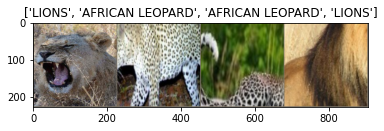

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) #  замена размерностей
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # пауза для обновления графиков


# треннировочные данные
inputs, classes = next(iter(dataloaders['train']))

# создание сетки из inputs
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() # начальное время

    best_model_wts = copy.deepcopy(model.state_dict()) # переменная, в которую сохраним лучшую модель
    best_acc = 0.0 # точность лучшей модели

    for epoch in range(num_epochs): # проход по эпохам
        print(f'Epoch {epoch}/{num_epochs - 1}') # вывод информации по каждой эпохе
        print('-' * 10)

        # состояния модели (тренировочная, валидационная)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # установить модель в режим обучения
            else:
                model.eval()   # установить модель в режим валидации

            running_loss = 0.0 # инициализация значения функции потерь
            running_corrects = 0 # инициализация значения верных предсказаний

            # перебор данных
            for inputs, labels in dataloaders[phase]:
                #отправка данных на gpu или cpu
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуление градиентов
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # результат применения модели к входным данным
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) # рассчет значения функции потерь

                    # оптимизация на фазе обучения с использованием алгоритма обратного распространения ошибки
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # состовления отчёта по каждой эпохе
                running_loss += loss.item() * inputs.size(0) # пополнение суммы функции ошибок
                running_corrects += torch.sum(preds == labels.data) # пополнение суммы корректных предсказаний
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase] # рассчет среднего значений функции потерь по всему датасету
            epoch_acc = running_corrects.double() / dataset_sizes[phase] # рассчет части верных предсказаний

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # глубокое копирование модели
            if phase == 'val' and epoch_acc > best_acc: # выбор весов с лучшим результом на валидации
                best_acc = epoch_acc # запоминание лучшей точности
                best_model_wts = copy.deepcopy(model.state_dict()) # запоминание веса

        print()

    time_elapsed = time.time() - since
    # вывод времени и лучшей точности
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # загрузка лучшей модели
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6): # показывает картинку и класс, который предсказала модель
    was_training = model.training # сохранение прошлого режима обучения
    model.eval() # переход в режим проверки
    images_so_far = 0 # счетчик 
    fig = plt.figure() 

    with torch.no_grad(): # отключение рассчёта градиентов
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device) # отправка данных  на рабочее устройство (gpu или cpu)
            labels = labels.to(device) # отправка данных  на рабочее устройство (gpu или cpu)

            outputs = model(inputs) # результат применения модели к входным данным
            _, preds = torch.max(outputs, 1) # предсказание более вероятного класса

            for j in range(inputs.size()[0]): # идем по батчу
                images_so_far += 1 # увеличение счётчика на 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}') # вывод предсказанного класса
                imshow(inputs.cpu().data[j]) # вывод изображения

                if images_so_far == num_images: # остановка, если показали достаточно примеров
                    model.train(mode=was_training) # возврат к прошлому режиму обучения
                    return
        model.train(mode=was_training) # перевод модели в режим обучения

In [ ]:
model_ft = models.resnet18(pretrained=True) # создание предобученной модели resnet18 
num_ftrs = model_ft.fc.in_features
# размер каждого выходного образца установлен равным двум
# В качестве альтернативы, это может быть обобщено в nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2) # ещё один слой

model_ft = model_ft.to(device) # копирование модели на рабочее устройство (gpu или cpu)

criterion = nn.CrossEntropyLoss() # кросс-энтропия

# Оптимизатор
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Выбор того, как изменяется lr с течением эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=6) # обучение

Epoch 0/5
----------
train Loss: 0.3558 Acc: 0.8578
val Loss: 0.0231 Acc: 1.0000

Epoch 1/5
----------
train Loss: 0.3633 Acc: 0.8793
val Loss: 0.0040 Acc: 1.0000

Epoch 2/5
----------
train Loss: 0.3851 Acc: 0.8707
val Loss: 0.1151 Acc: 1.0000

Epoch 3/5
----------
train Loss: 0.3183 Acc: 0.8922
val Loss: 0.0349 Acc: 1.0000

Epoch 4/5
----------
train Loss: 0.2016 Acc: 0.9310
val Loss: 0.0022 Acc: 1.0000

Epoch 5/5
----------
train Loss: 0.1934 Acc: 0.9397
val Loss: 0.0040 Acc: 1.0000

Training complete in 13m 49s
Best val Acc: 1.000000


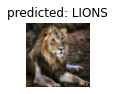

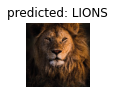

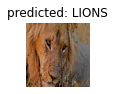

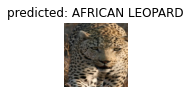

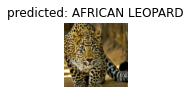

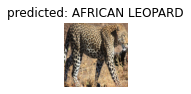

In [ ]:
visualize_model(model_ft) # визуализация результата

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True) # создание предобученной модели resnet18 
for param in model_conv.parameters(): # отключаем обучение всех предобученных параметров
    param.requires_grad = False

# Параметры вновь созданных модулей по умолчанию имеют requires_grad=True
num_ftrs = model_conv.fc.in_features # фичи на полносвязном слое
model_conv.fc = nn.Linear(num_ftrs, 2) # ещё один слой

model_conv = model_conv.to(device) # копирование модели на рабочее устройство (gpu или cpu)

criterion = nn.CrossEntropyLoss() # кросс-энтропия

# оптимизируются только параметры конечного слоя
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9) # выбираем метод изменения параметров

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1) # выбираем метод изменения скрорости обучения

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=6)
# обучаем модель

Epoch 0/5
----------
train Loss: 0.4827 Acc: 0.7672
val Loss: 0.0184 Acc: 1.0000

Epoch 1/5
----------
train Loss: 0.4031 Acc: 0.8513
val Loss: 0.0334 Acc: 1.0000

Epoch 2/5
----------
train Loss: 0.3102 Acc: 0.8793
val Loss: 0.0137 Acc: 1.0000

Epoch 3/5
----------
train Loss: 0.3091 Acc: 0.8556
val Loss: 0.0140 Acc: 1.0000

Epoch 4/5
----------
train Loss: 0.2395 Acc: 0.8944
val Loss: 0.0031 Acc: 1.0000

Epoch 5/5
----------
train Loss: 0.3539 Acc: 0.8642
val Loss: 0.0129 Acc: 1.0000

Training complete in 5m 4s
Best val Acc: 1.000000


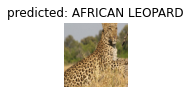

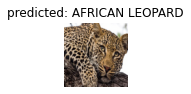

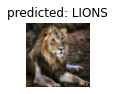

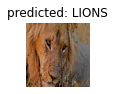

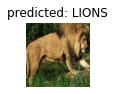

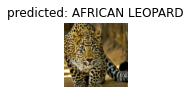

In [ ]:
visualize_model(model_conv) # визуализация результата

plt.ioff()
plt.show()

### Вывод

При отключении предобученных слоев из обучения, модель обучается значительно быстрее, при этом потеря в точности незначительна, потому transferlearning может сократить время обучения для многих узконправленных моделей в бизнесе